In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [4]:
! ls ../data/raw/birdclef-2021/

train_soundscape_labels.csv
train_soundscapes


In [40]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

birdclef_2021 = Path("../data/raw/birdclef-2021")
labels_df = pd.read_csv(birdclef_2021 / "train_soundscape_labels.csv")
labels_df

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall
...,...,...,...,...,...
2395,54955_SSW_580,SSW,54955,580,nocall
2396,54955_SSW_585,SSW,54955,585,grycat
2397,54955_SSW_590,SSW,54955,590,grycat
2398,54955_SSW_595,SSW,54955,595,nocall


In [41]:
labels_df[labels_df.birds == "nocall"].shape

(1529, 5)

In [42]:
soundscapes_path = list((birdclef_2021 / "train_soundscapes").glob("*"))
soundscapes_path[:3]

[WindowsPath('../data/raw/birdclef-2021/train_soundscapes/10534_SSW_20170429.ogg'),
 WindowsPath('../data/raw/birdclef-2021/train_soundscapes/11254_COR_20190904.ogg'),
 WindowsPath('../data/raw/birdclef-2021/train_soundscapes/14473_SSW_20170701.ogg')]

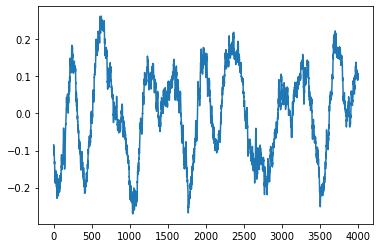

In [27]:
import librosa

sr = 32000
y, sr = librosa.load(soundscapes_path[0], sr=sr)
plt.plot(y[:4000])

In [44]:
import numpy as np


def slice_seconds(data, sample_rate, seconds=5, pad_seconds=0):
    # return 2d array of the original data
    n = len(data)
    k = sample_rate * seconds
    pad = sample_rate * pad_seconds
    indexes = np.array(
        [np.arange(i, i + k + pad) for i in range(0, n, k) if i + k + pad <= n]
    )
    indexed = data[indexes]
    return list(zip((np.arange(len(indexed)) + 1) * 5, indexed))


def parse_metadata(path: Path) -> dict:
    audio_id, site, _ = path.name.split("_")
    return dict(audio_id=audio_id, site=site)


def parse_soundscape(path: Path, sr=32000, window=5) -> pd.DataFrame:
    """Convert a soundscape into the expected labeling format."""
    y, _ = librosa.load(path, sr=sr)
    df = pd.DataFrame(slice_seconds(y, sr, window), columns=["seconds", "x"])
    for key, value in parse_metadata(path).items():
        df[key] = value
    df["row_id"] = df.apply(
        lambda row: f"{row.audio_id}_{row.site}_{row.seconds}", axis=1
    )
    return df[["row_id", "audio_id", "site", "seconds", "x"]]


def load_training_soundscapes(train_root: Path) -> pd.DataFrame:
    res = []
    for path in train_root.glob("*"):
        df = parse_soundscape(path)
        res.append(df)
    return pd.concat(res)


parse_metadata(soundscapes_path[0])
parse_soundscape(soundscapes_path[0])

,row_id,audio_id,site,seconds,x
0,10534_SSW_5,10534,SSW,5,"[-0.08470473, -0.112296015, -0.087516725, -0.1..."
1,10534_SSW_10,10534,SSW,10,"[-0.06234489, -0.057403825, -0.052087434, -0.0..."
2,10534_SSW_15,10534,SSW,15,"[-0.08092993, -0.096321814, -0.10212809, -0.08..."
3,10534_SSW_20,10534,SSW,20,"[-0.07888239, -0.08303972, -0.077026635, -0.07..."
4,10534_SSW_25,10534,SSW,25,"[0.083922505, 0.06641949, 0.071692884, 0.07737..."
...,...,...,...,...,...
115,10534_SSW_580,10534,SSW,580,"[-0.08814933, -0.07088068, -0.07537036, -0.070..."
116,10534_SSW_585,10534,SSW,585,"[0.05698984, 0.044403374, 0.024299078, 0.03061..."
117,10534_SSW_590,10534,SSW,590,"[-0.01143652, -0.013098279, -0.0076669427, -0...."
118,10534_SSW_595,10534,SSW,595,"[-0.125591, -0.12963934, -0.13891548, -0.13467..."


In [46]:
data_df = load_training_soundscapes(birdclef_2021 / "train_soundscapes")

In [48]:
labels_df.head()

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall


In [54]:
def prepare_training_dataset(
    labels_df: pd.DataFrame, data_df: pd.DataFrame
) -> pd.DataFrame:
    df = labels_df.merge(data_df[["row_id", "x"]], on="row_id")
    df["y"] = (df.birds != "nocall").astype(int)
    return df[["x", "y"]]


training_df = prepare_training_dataset(labels_df, data_df)

In [55]:
training_df

,x,y
0,"[-0.08553279, -0.08384135, -0.041250665, -0.01...",0
1,"[0.021114878, 0.003057547, -0.02268604, 0.0004...",0
2,"[0.018344874, 0.04597478, 0.05685617, 0.049335...",0
3,"[-0.10187924, -0.13058019, -0.11406977, -0.125...",0
4,"[0.05506949, 0.050840594, 0.057296656, 0.06219...",0
...,...,...
2395,"[-0.03387017, -0.024345992, -0.016776666, -0.0...",0
2396,"[0.1394074, 0.14445972, 0.14525153, 0.14363474...",1
2397,"[-0.0086922, -0.013638088, -0.022163874, -0.01...",1
2398,"[0.055847555, 0.041066542, 0.025795452, 0.0165...",0
